In [28]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
from pricing_tools import *
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm

### Leemos el diccionario de variables

In [29]:
dict_path=r'../src/data_dict.xlsx'
dict = pd.read_excel(dict_path)
dict.head()

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.0,0,1.0,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.0,0,1.0,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.0,0,1.0,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.0,0,1.0,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.0,0,1.0,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA


### Leemos el dataframe

In [30]:
df_path=r'../src/AGUAACAGBC'
df=pd.read_parquet(df_path)
df.head()

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,...,zona_inundable_centroids,zonas_agri,zonas_de_extraccion_minera,zonas_en_construccion,zonas_fore,zonas_hume,zonas_industriales_o_comerciales,zonas_portuarias,zonas_quemadas,zonas_verdes_urbanas
0,1033.0,552.0,31.0,NaN,31.0,99.0,4.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
1,1033.0,552.0,30.0,NaN,30.0,99.0,3.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
2,1033.0,552.0,33.0,NaN,33.0,99.0,6.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
3,1033.0,552.0,34.0,NaN,34.0,99.0,7.0,1961.0,1961.0,3.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN
4,1033.0,552.0,36.0,NaN,36.0,99.0,6.0,1961.0,1961.0,0.0,...,1.0,60.339419,2.297298,NaN,30.170863,NaN,7.73435,NaN,NaN,NaN


In [31]:
#Por si llegase a ser necesario reducir el tamaño del df para el analisis
df_muestra = df.sample(n=len(df))

In [32]:
###Definimos las variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

In [33]:
df_muestra=df_muestra[df_muestra[peso]>0] #Necesitamos que la poliza tenga exposición

In [34]:
df_muestra['resp']=df_muestra[var_resp]/df_muestra[peso]

In [35]:
def graficar_histograma(df, columna, bins=10, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia"):
    """
    Grafica un histograma de una variable específica de un DataFrame.
    
    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna que se desea graficar (str).
    - bins: Número de bins en el histograma (opcional, por defecto 10).
    - titulo: Título del gráfico (opcional).
    - xlabel: Etiqueta para el eje X (opcional).
    - ylabel: Etiqueta para el eje Y (opcional).
    """
    # Comprobamos si la columna existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return
    
    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(df[columna].dropna(), bins=bins, color="skyblue", edgecolor="black")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

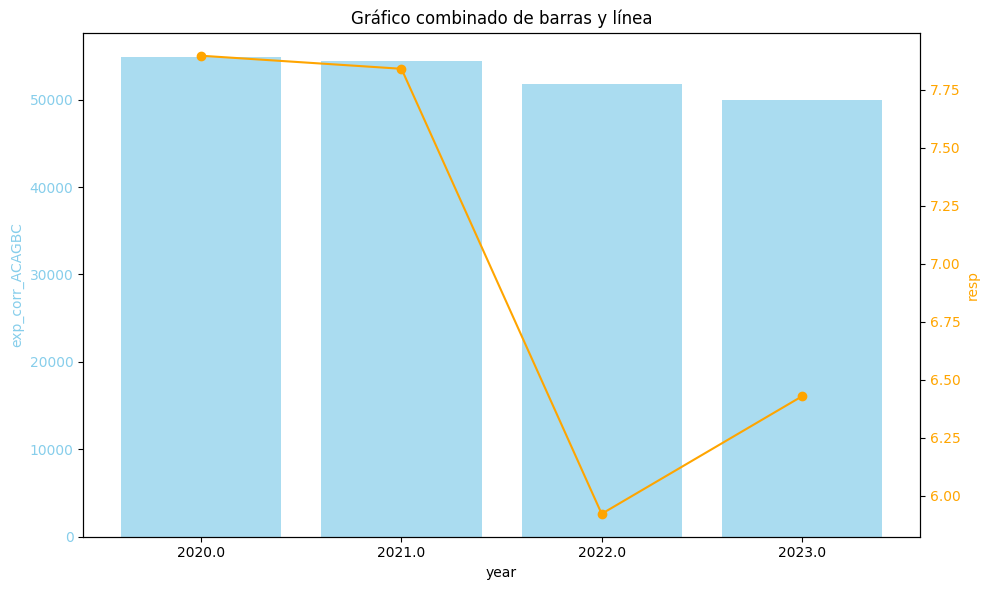

In [36]:
#Estudiamos la composicion de la cartera por años
df_muestra[ano]=df_muestra[ano].astype(str)
df_resumido = df_muestra.groupby(ano).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,ano,peso,'resp')

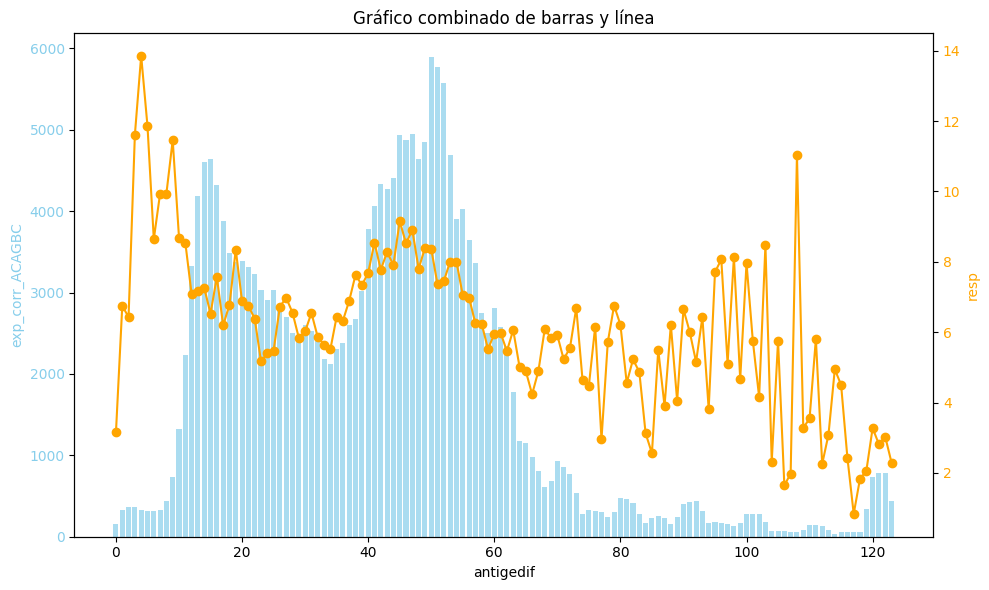

In [37]:
### Ejemplo variable importante 
### Antiguedad del edificio
var='antigedif'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

In [38]:
antig_corregida=generar_formato_exposicion_homogenea(df_muestra, 'antigedif', peso, 10)
df_muestra['antigedif_2']=antig_corregida #Sobreescribimos la columna corregida

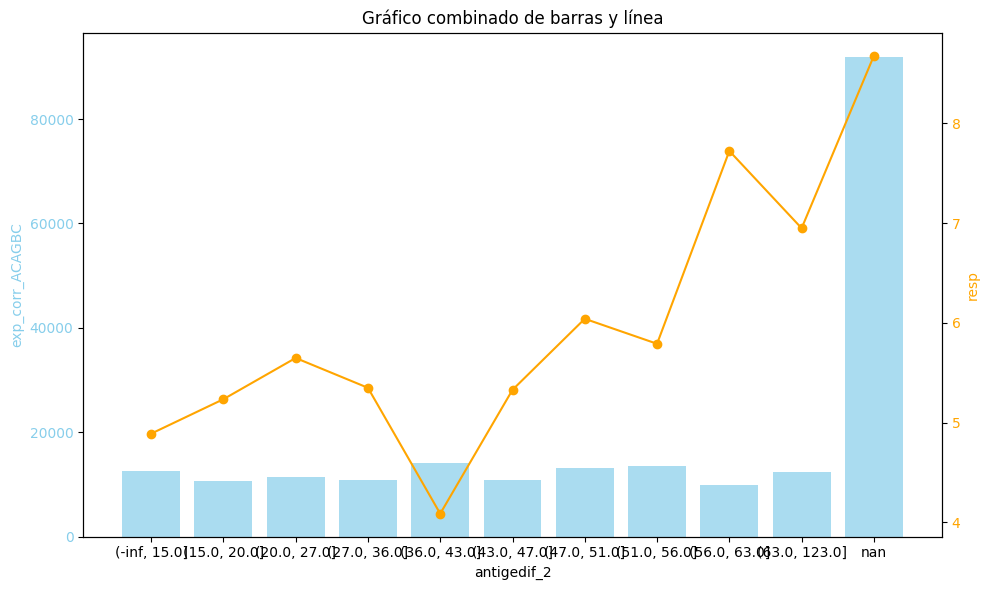

In [39]:
df_muestra['antigedif_2']=df_muestra['antigedif_2'].astype(str)
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [40]:
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['antigedif_2'].replace('nan',np.nan).mode(dropna=True)[0]

'(51.0, 56.0]'

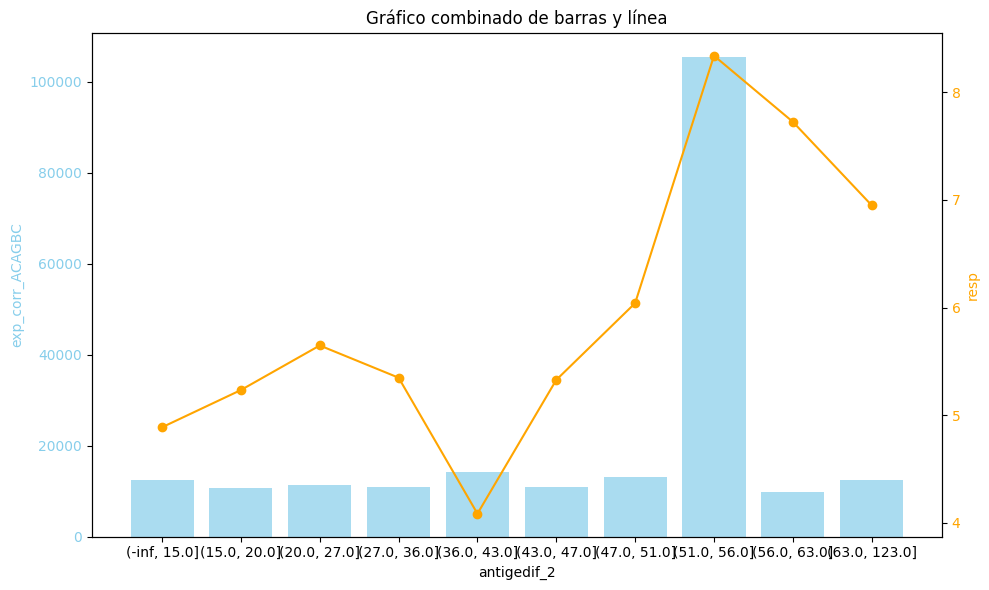

In [41]:
### Ahora sustituimos los nan por el valor moda
df_muestra['antigedif_2']=df_muestra['antigedif_2'].replace('nan','(51.0, 56.0]')
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [42]:
factores=['year','antigedif_2','anualidad_seguro','FP','K_ACAGBC','SUPERFICIE','stro_1a_AGUAACAGBC','NIF_TIPO']
df_muestra[factores].dtypes

year                   object
antigedif_2            object
anualidad_seguro      float64
FP                    float64
K_ACAGBC              float64
SUPERFICIE            float64
stro_1a_AGUAACAGBC    float64
NIF_TIPO               object
dtype: object

In [43]:
# Creamos variables dummy para las columnas categóricas
key_words=['year', 'antigedif_2','NIF_TIPO']
df_encoded = pd.get_dummies(df_muestra, columns=key_words, drop_first=True)

In [44]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

['year_2021.0',
 'year_2022.0',
 'year_2023.0',
 'antigedif_2_(15.0, 20.0]',
 'antigedif_2_(20.0, 27.0]',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(36.0, 43.0]',
 'antigedif_2_(43.0, 47.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(56.0, 63.0]',
 'antigedif_2_(63.0, 123.0]',
 'NIF_TIPO_J',
 'NIF_TIPO_N']

In [45]:
factores_updated=[each for each in factores if each not in key_words]
factores_updated

['anualidad_seguro', 'FP', 'K_ACAGBC', 'SUPERFICIE', 'stro_1a_AGUAACAGBC']

In [46]:
list(set(cols_encoded+factores_updated))

['antigedif_2_(63.0, 123.0]',
 'year_2022.0',
 'year_2021.0',
 'antigedif_2_(43.0, 47.0]',
 'K_ACAGBC',
 'stro_1a_AGUAACAGBC',
 'FP',
 'year_2023.0',
 'NIF_TIPO_J',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(15.0, 20.0]',
 'NIF_TIPO_N',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(20.0, 27.0]',
 'anualidad_seguro',
 'SUPERFICIE',
 'antigedif_2_(56.0, 63.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(36.0, 43.0]']

In [47]:
# Prepara los datos
df_encoded = df_encoded[list(set(cols_encoded+factores_updated))].astype('float')
X=df_encoded# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               542164
Model:                            GLM   Df Residuals:                   542144
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3709e+07
Date:                Thu, 27 Mar 2025   Deviance:                   4.6860e+07
Time:                        23:24:12   Pearson chi2:                 1.32e+10
No. Iterations:                    28   Pseudo R-squ. (CS):             0.9985
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [48]:
def calculate_bic(model):
    n = len(model.model.endog)  # Número de observaciones
    k = model.df_model + 1  # Número de parámetros (df_model incluye los coeficientes, sumamos 1 por el intercepto)
    bic = np.log(n) * k - 2 * model.llf  # BIC = ln(n) * k - 2 * log-verosimilitud
    return bic
calculate_bic(resultado)

47417265.48605139

In [49]:
factores=['year','antigedif_2','anualidad_seguro','FP','K_ACAGBC','SUPERFICIE','stro_1a_AGUAACAGBC']
df_muestra[factores].dtypes

year                   object
antigedif_2            object
anualidad_seguro      float64
FP                    float64
K_ACAGBC              float64
SUPERFICIE            float64
stro_1a_AGUAACAGBC    float64
dtype: object

In [50]:
# Creamos variables dummy para las columnas categóricas
key_words=['year', 'antigedif_2']
df_encoded = pd.get_dummies(df_muestra, columns=key_words, drop_first=True)

In [51]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

['year_2021.0',
 'year_2022.0',
 'year_2023.0',
 'antigedif_2_(15.0, 20.0]',
 'antigedif_2_(20.0, 27.0]',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(36.0, 43.0]',
 'antigedif_2_(43.0, 47.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(56.0, 63.0]',
 'antigedif_2_(63.0, 123.0]']

In [52]:
factores_updated=[each for each in factores if each not in key_words]
factores_updated

['anualidad_seguro', 'FP', 'K_ACAGBC', 'SUPERFICIE', 'stro_1a_AGUAACAGBC']

In [53]:
# Prepara los datos
df_encoded = df_encoded[list(set(cols_encoded+factores_updated))].astype('float')
X=df_encoded# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo1 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado1 = modelo1.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               542164
Model:                            GLM   Df Residuals:                   542144
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3709e+07
Date:                Thu, 27 Mar 2025   Deviance:                   4.6860e+07
Time:                        23:24:23   Pearson chi2:                 1.32e+10
No. Iterations:                    28   Pseudo R-squ. (CS):             0.9985
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [54]:
calculate_bic(resultado1)

47547248.280846044